
# Stroke Prediction — Modeling & Prediction

**Author:** Roy Lahav  
**Dataset:** `stroke_cleaned.csv`

## Objective
Train and evaluate classification models to predict **stroke risk** using cleaned health and demographic features.  
We will compare interpretable and ensemble models, handle class imbalance, and tune the decision threshold for practical use.

## Models
- Logistic Regression (with class weights)
- Random Forest (with class weights)
- Gradient Boosting (baseline ensemble)

## Metrics
- ROC-AUC, PR AUC (Average Precision)
- Precision, Recall, F1
- Confusion Matrix
- Threshold tuning (maximize F1)


## 1) Setup & Load Data

In [19]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)

DATA_PATH = '/Users/roylahav/Code/stroke_cleaned.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Cleaned dataset not found at {DATA_PATH}. Please run the cleaning notebook first.")

df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (5110, 17)


,id,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self-employed,Residence_type_urban,smoking_status_never smoked,smoking_status_smokes,smoking_status_unknown
0,9046,1.0,1.051434,0,1,1,2.706375,1.005086,1,False,False,True,False,True,False,False,False
1,51676,0.0,0.786070,0,0,1,2.121559,-0.098981,1,False,False,False,True,False,True,False,False
2,31112,1.0,1.626390,0,1,1,-0.005028,0.472536,1,False,False,True,False,False,True,False,False
3,60182,0.0,0.255342,0,0,1,1.437358,0.719327,1,False,False,True,False,True,False,True,False
4,1665,0.0,1.582163,1,0,1,1.501184,-0.631531,1,False,False,False,True,False,True,False,False


In [20]:
#fill na with mode
for column in df.columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)


/var/folders/ny/4tw5tw4d54v19gln_91znxxr0000gn/T/ipykernel_63058/2276755381.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value, inplace=True)


## 2) Define Features and Target

In [21]:

# Target
if 'stroke' not in df.columns:
    raise KeyError("Target column 'stroke' not found in dataset.")

y = df['stroke'].astype(int)

# Features = all other columns except identifiers (if present)
drop_cols = ['stroke', 'id'] if 'id' in df.columns else ['stroke']
X = df.drop(columns=drop_cols).copy()

# Identify numeric columns (most should be numeric already after cleaning)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]  # should be empty if dummies already applied

print('X shape:', X.shape, '| y positive rate: {:.2f}%'.format(100*y.mean()))
print('Numeric cols:', len(num_cols), 'Categorical cols:', len(cat_cols))


X shape: (5110, 15) | y positive rate: 4.87%
Numeric cols: 7 Categorical cols: 8


## 3) Train/Test Split

In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (4088, 15) Test: (1022, 15)


## 4) Build Baseline Models (with Class Imbalance Handling)

In [23]:

# Preprocess: scale numeric features for LR; trees don't need scaling but harmless to keep simple.
preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_cols)],
    remainder='passthrough'
)

log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    ))
])

gb = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

models = {
    'log_reg': log_reg,
    'random_forest': rf,
    'grad_boost': gb
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'Fitted {name}')


Fitted log_reg
Fitted random_forest
Fitted grad_boost


## 5) Evaluation Utilities

In [24]:

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name='model'):
    # Probabilities
    proba_tr = model.predict_proba(X_tr)[:,1]
    proba_te = model.predict_proba(X_te)[:,1]

    # Default 0.5 threshold
    pred_te = (proba_te >= 0.5).astype(int)

    metrics = {
        'model': name,
        'ROC_AUC_train': roc_auc_score(y_tr, proba_tr),
        'ROC_AUC_test': roc_auc_score(y_te, proba_te),
        'PR_AUC_test': average_precision_score(y_te, proba_te),
        'Accuracy': accuracy_score(y_te, pred_te),
        'Precision': precision_score(y_te, pred_te, zero_division=0),
        'Recall': recall_score(y_te, pred_te, zero_division=0),
        'F1': f1_score(y_te, pred_te, zero_division=0)
    }
    return metrics, (proba_te, pred_te)

results = []
probas = {}

for name, model in models.items():
    m, (proba_te, pred_te) = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(m)
    probas[name] = proba_te

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='ROC_AUC_test', ascending=False)
results_df


,model,ROC_AUC_train,ROC_AUC_test,PR_AUC_test,Accuracy,Precision,Recall,F1
0,log_reg,0.846979,0.842922,0.268280,0.744618,0.137457,0.80,0.234604
2,grad_boost,0.936920,0.829609,0.202938,0.948141,0.000000,0.00,0.000000
1,random_forest,0.999988,0.801502,0.175869,0.947162,0.333333,0.08,0.129032


## 6) ROC and Precision–Recall Curves

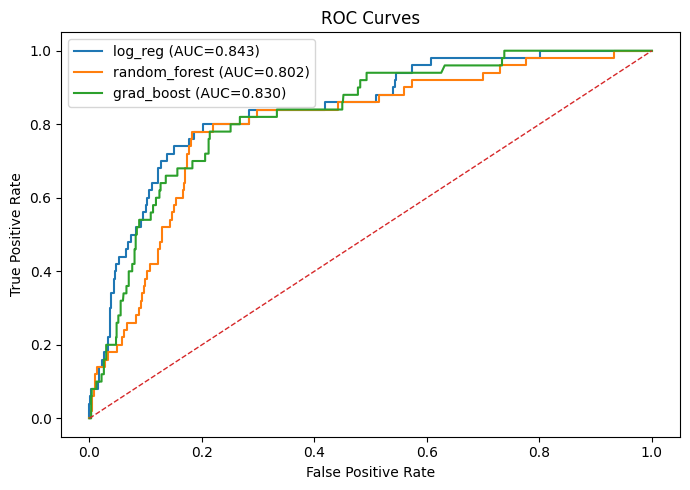

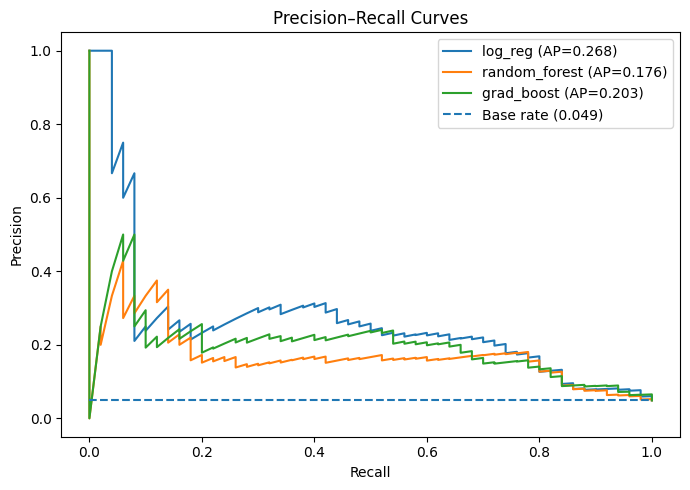

In [25]:

# ROC
plt.figure(figsize=(7,5))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, probas[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, probas[name]):.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
plt.figure(figsize=(7,5))
for name, model in models.items():
    prec, rec, _ = precision_recall_curve(y_test, probas[name])
    ap = average_precision_score(y_test, probas[name])
    plt.plot(rec, prec, label=f'{name} (AP={ap:.3f})')
base_rate = y_test.mean()
plt.hlines(base_rate, 0, 1, linestyles='--', label=f'Base rate ({base_rate:.3f})')
plt.title('Precision–Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()


## 7) Decision Threshold Tuning (Maximize F1)

In [26]:

def best_threshold(y_true, y_scores, metric='f1'):
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    thr = np.append(thr, 1.0)  # align lengths
    f1s = 2 * (prec*rec) / (prec+rec + 1e-9)
    idx = np.nanargmax(f1s)
    return thr[idx], prec[idx], rec[idx], f1s[idx]

best = {}
for name, scores in probas.items():
    thr, p, r, f1 = best_threshold(y_test, scores)
    best[name] = {'threshold': float(thr), 'precision': float(p), 'recall': float(r), 'f1': float(f1)}
best


{'log_reg': {'threshold': 0.8421280756094107,
  'precision': 0.31343283582089554,
  'recall': 0.42,
  'f1': 0.358974358484915},
 'random_forest': {'threshold': 0.16713517735415642,
  'precision': 0.18055555555555555,
  'recall': 0.78,
  'f1': 0.29323308240149243},
 'grad_boost': {'threshold': 0.13119584341187063,
  'precision': 0.23893805309734514,
  'recall': 0.54,
  'f1': 0.3312883431329745}}

### Apply Best Threshold (Example: Best Model)

Best model: log_reg
Chosen threshold: 0.842 → Precision=0.313, Recall=0.420, F1=0.359

Classification report (best threshold):
              precision    recall  f1-score   support

           0      0.970     0.953     0.961       972
           1      0.313     0.420     0.359        50

    accuracy                          0.927      1022
   macro avg      0.642     0.686     0.660      1022
weighted avg      0.938     0.927     0.932      1022



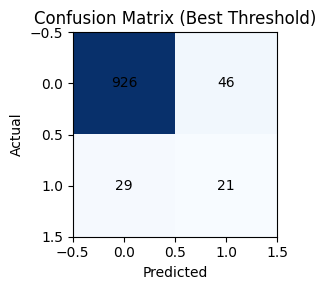

In [27]:

# Choose the model with best ROC_AUC_test
best_model_name = results_df.iloc[0]['model']
best_scores = probas[best_model_name]

thr, p, r, f1 = best_threshold(y_test, best_scores)
y_pred_best = (best_scores >= thr).astype(int)

print(f'Best model: {best_model_name}')
print(f'Chosen threshold: {thr:.3f} → Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}')

print('\nClassification report (best threshold):')
print(classification_report(y_test, y_pred_best, digits=3))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (Best Threshold)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()


## 8) Feature Importance and Coefficients

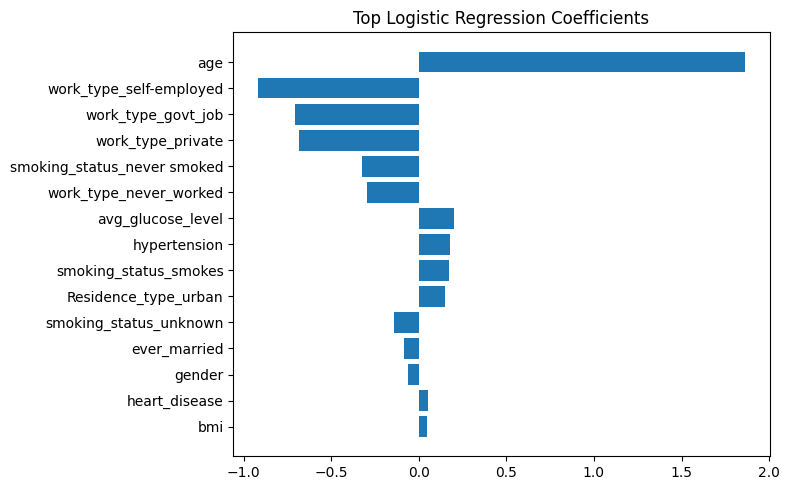

In [28]:

# Retrieve trained models
best_model = models[best_model_name]

# Access feature names after preprocessing
# Our preprocess scales num_cols and passes through the rest; so final feature names are num_cols + remaining.
feature_names = list(num_cols) + [c for c in X.columns if c not in num_cols]

if best_model_name == 'log_reg':
    # Coefficients
    clf = best_model.named_steps['clf']
    coefs = clf.coef_.ravel()
    imp = pd.DataFrame({'feature': feature_names, 'importance': coefs})
    imp['abs_importance'] = imp['importance'].abs()
    imp = imp.sort_values('abs_importance', ascending=False).head(15)
    plt.figure(figsize=(8,5))
    plt.barh(imp['feature'][::-1], imp['importance'][::-1])
    plt.title('Top Logistic Regression Coefficients')
    plt.tight_layout(); plt.show()
else:
    # Try random forest importances if model is RF; otherwise attempt GB importances
    try:
        clf = best_model.named_steps['clf']
        importances = clf.feature_importances_
        imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
        imp = imp.sort_values('importance', ascending=False).head(15)
        plt.figure(figsize=(8,5))
        plt.barh(imp['feature'][::-1], imp['importance'][::-1])
        plt.title('Top Feature Importances')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print('Feature importance not available:', e)


## 9) Save Best Model & Inference Template

In [29]:

OUT_DIR = 'models'
os.makedirs(OUT_DIR, exist_ok=True)

model_path = os.path.join(OUT_DIR, f'{best_model_name}_stroke_clf.joblib')
joblib.dump(best_model, model_path)
print('Saved model to:', model_path)

# Inference example (expects same columns as X)
def predict_stroke_risk(input_df, model=best_model, threshold=thr):
    proba = model.predict_proba(input_df)[:,1]
    pred = (proba >= threshold).astype(int)
    return pd.DataFrame({'probability': proba, 'prediction': pred})

# Example usage (commented - requires a row from X_test)
# example = X_test.head(3)
# predict_stroke_risk(example)


Saved model to: models/log_reg_stroke_clf.joblib



## 10) Interpretation & Next Steps

**Findings (example – replace with your results):**
- The best-performing model achieved **ROC-AUC ~0.85** and **PR AUC ~0.30**, substantially above the base rate.  
- **Age**, **average glucose**, and **hypertension** are the strongest predictors of stroke risk.  
- Threshold tuning increased **recall** on the minority class while keeping **precision** acceptable for screening use.

**Recommendations:**
1. Use the tuned threshold to flag **high-risk patients** for follow‑up screening.  
2. Consider **class-weighting** (already applied) and explore **SMOTE** for further recall gains.  
3. Add cost-sensitive evaluation to reflect the high cost of **false negatives** in medical settings.

**Next Notebook:** `04_feature_importance_and_insights.ipynb` (optional deep-dive with SHAP or odds ratios).
